# Analyse de la décharge de voitures à Hangzhou en Chine
Ce notebook se concentre sur l'étude de la écharge de voitures à Hangzhou en Chine. Les fichiers TIFF utilisés dans cette analyse ont été obtenus après un pré-traitement sur le logiciel `SNAP`SeNtinel Application Platform qui est un logiciel développé par l'Agence spatiale
européenne, conçu pour le traitement et l'analyse des données satellites. préliminaire visant à aligner toutes les images sur la première. Cette étape de recalage permet une comparaison cohérente entre les différentes captures d'images, facilitant ainsi l'analyse ultérieure de la décharge de voitures et le suivi de la superficie de la décharge.

In [1]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import scipy.ndimage as nd
from astropy.convolution import convolve
import scipy.stats
from tqdm import tqdm
from skimage.restoration import denoise_tv_bregman
from numpy.linalg import norm
import scipy
import bm3d
from skimage import io, img_as_ubyte, morphology, color
import cv2
from skimage.color import rgb2gray
import os
import re

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Ouverture automatique des fichiers 


La forme du nom de fichier "20170103_20200405_Orb_Stack.tif" par exemple  est  exprimée comme "Date de l'image sur laquelle on fait le recalage_Date de l'image_Orb_Stack.tif"  
Dans la cellule suivante du code on fera le tri selon les dates et on extrait les dates des noms de fichiers0

In [3]:
# Dossier contenant les images
dossier = "C:/Users/Paul Fouilhac/Documents/Projet Commande Entreprise/Images/Images Hangzhou_&_AltoHospicio/Images Hangzhou"

# Obtenez la liste des fichiers dans le dossier
liste_fichiers = os.listdir(dossier)
pattern = re.compile(r"(\d{8})_(\d{8})")  # Deux groupes de huit chiffres

# Créez une liste de tuples (nom de fichier, date extraite)
fichiers_dates = [(fichier, re.search(pattern, fichier).groups()) for fichier in liste_fichiers if re.search(pattern, fichier)]

# Triez la liste de tuples par date
fichiers_dates_tries = sorted(fichiers_dates, key=lambda x: x[1])

# Créez une liste ordonnée des noms de fichiers et des dates
fichiers_ordonnes = [fichier[0] for fichier in fichiers_dates_tries]
dates = [f"{fichier[1][1][6:]}/{fichier[1][1][4:6]}/{fichier[1][1][:4]}" for fichier in fichiers_dates_tries]

# Liste pour stocker les données des images dans l'ordre
Images_tif_ordonnees = []

# Charger les images dans l'ordre correspondant aux noms triés
for file_path in fichiers_ordonnes:
    try:
        print("Reading:", file_path)
        image_data = tifffile.imread(os.path.join(dossier, file_path))
        Images_tif_ordonnees.append(image_data)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        
dates.insert(0, "11/03/2018")
# Afficher les dates formattées
print("Dates des images étudiées:", dates)

# Continuer avec le reste de votre script...


Images = [Images_tif_ordonnees[3][0,:,:] + 1j*Images_tif_ordonnees[3][1,:,:]]


for k in range ( len(Images_tif_ordonnees)):
    Images.append(Images_tif_ordonnees[k][2,:,:] + 1j*Images_tif_ordonnees[k][3,:,:])




Reading: 20180311_20180907_Orb_Stack.tif
Reading: 20180311_20190211_Orb_Stack.tif
Reading: 20180311_20190622_Orb_Stack.tif
Reading: 20180311_20191020_Orb_Stack.tif
Reading: 20180311_20200124_Orb_Stack.tif
Reading: 20180311_20200129_Orb_Stack.tif
Reading: 20180311_20200803_Orb_Stack.tif
Reading: 20180311_20201107_Orb_Stack.tif
Reading: 20180311_20210211_Orb_Stack.tif
Dates des images étudiées: ['11/03/2018', '07/09/2018', '11/02/2019', '22/06/2019', '20/10/2019', '24/01/2020', '29/01/2020', '03/08/2020', '07/11/2020', '11/02/2021']


# Specification de la zone de pixels  

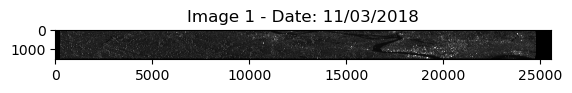

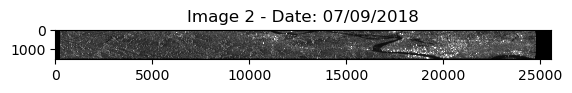

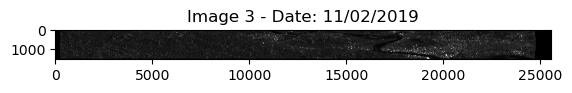

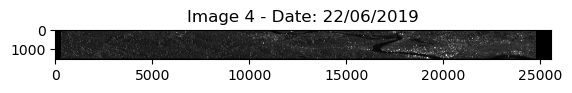

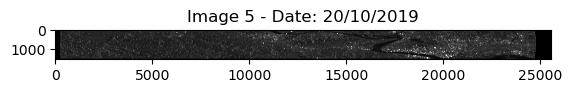

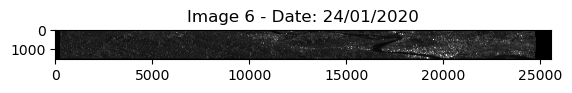

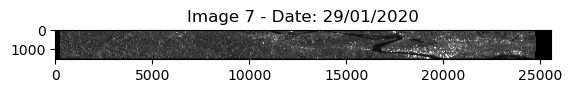

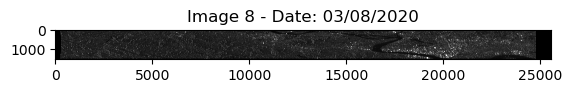

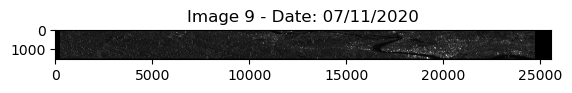

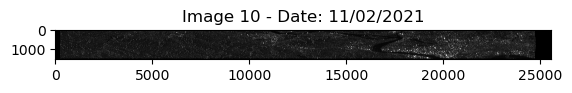

In [4]:
# Initialiser vmax avec 1/50 pour chaque image ( valeur par défaut)
vmax_values = [1/50] * len(Images)
#adapter la valeur vmax pour certaines images
vmax_values[6] = 1/100
vmax_values[1] = 1/100
for k in range(len(Images)):
    plt.imshow(np.abs(Images[k]), cmap="gray", vmax=vmax_values[k]* np.max(np.abs(Images[k])))
    plt.title(f"Image {k+1} - Date: {dates[k]}")
    plt.show()

In [5]:
sy = np.s_[625:725] 
sx = np.s_[16800:16925]

Images_rognees = []
for k in range(len(Images)):
    Images_rognees.append(Images[k][sy,sx])


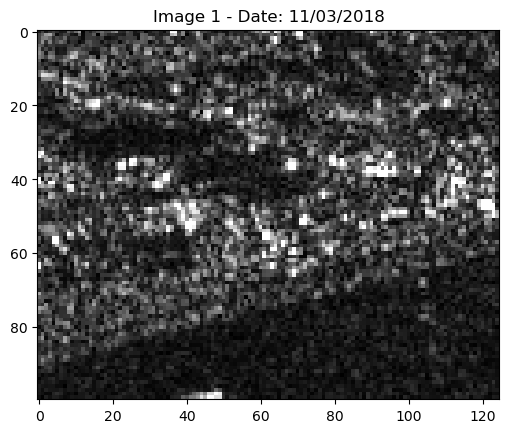

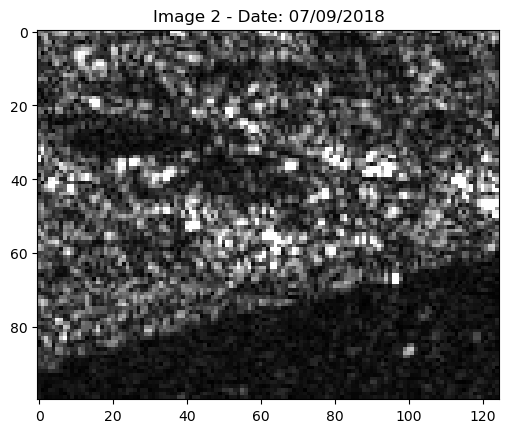

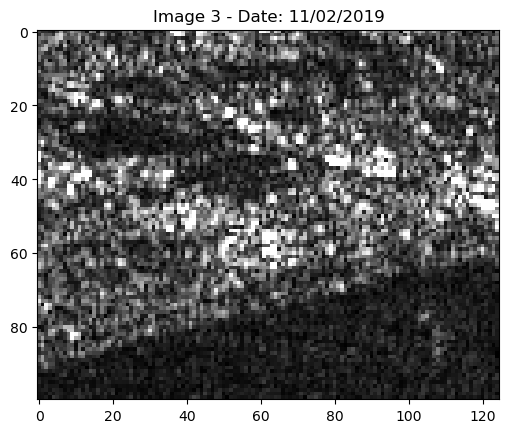

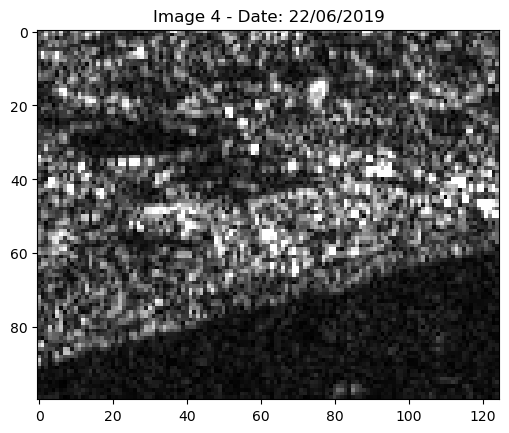

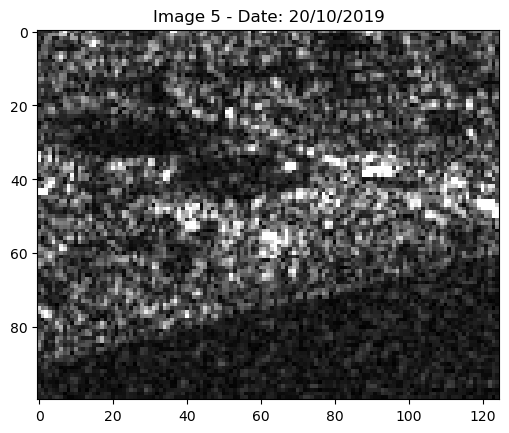

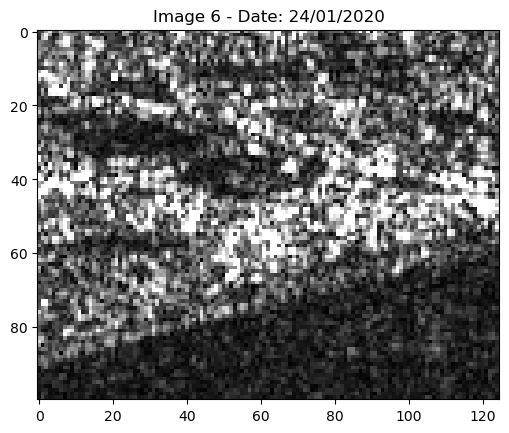

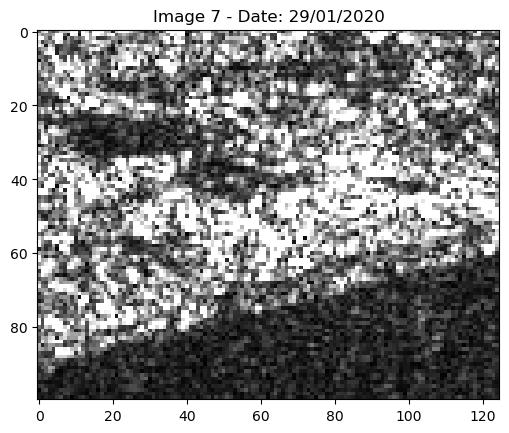

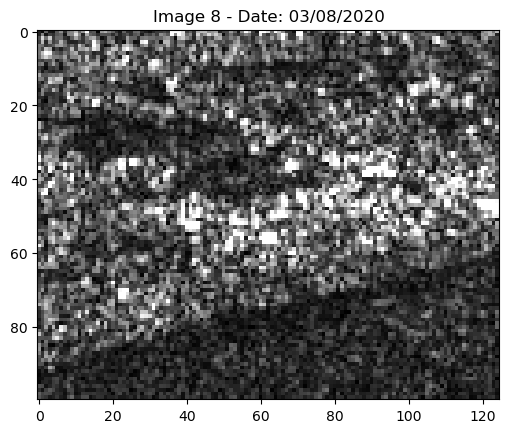

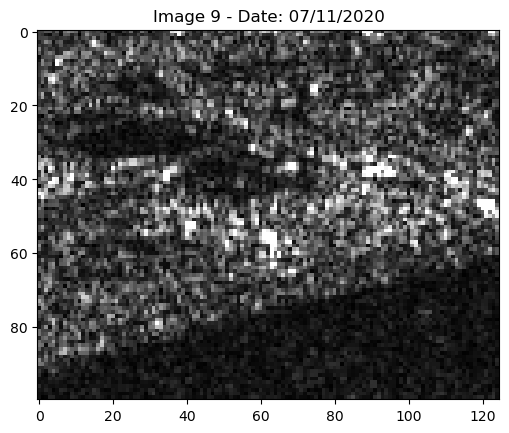

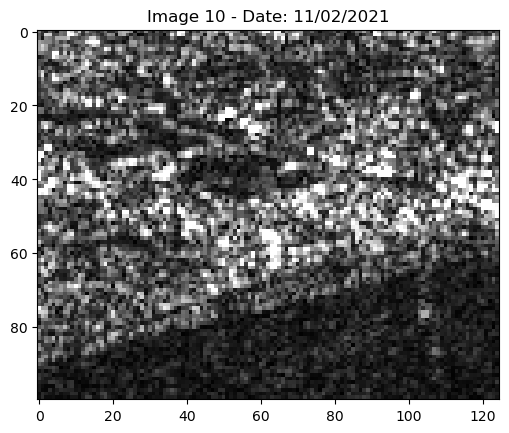

In [6]:
# Initialiser vmax avec 1/50 pour chaque image ( valeur par défaut)
vmax_values = [1/5] * len(Images)
#adapter la valeur vmax pour certaines images
vmax_values[6] = 1/10
for k in range(len(Images_rognees)):
    plt.imshow(np.abs(Images_rognees[k]), cmap="gray", vmax=vmax_values[k]* np.max(np.abs(Images_rognees[k])))
    plt.title(f"Image {k+1} - Date: {dates[k]}")
    plt.show()

# Forming the ratio image

In [7]:
reference_image = Images_rognees[0]
def ratio(img, reference_img):
    # Ajoutez une petite valeur à reference_img pour éviter la division par zéro
    for i in range (np.shape(reference_img)[0]):
        for j in range (np.shape(reference_img)[1]):
             if reference_img[i, j] == 0.+0.j:
                    reference_img[i, j] = 1e-3+0.j               
    return np.clip(img / reference_image, 1e-3, 10)

Ratios = []
for k in range(1, len(Images_rognees)):
     Ratios.append(np.real(ratio (Images_rognees[k], reference_image)))



# Image ratio réelle

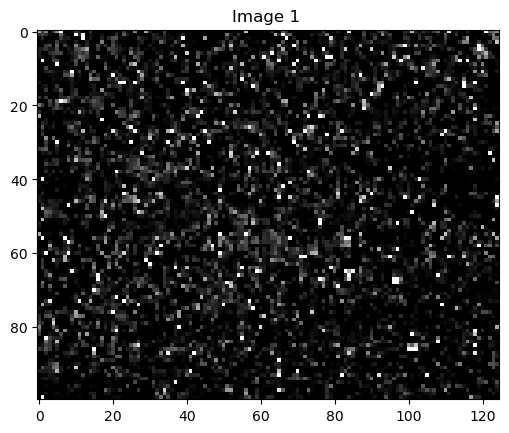

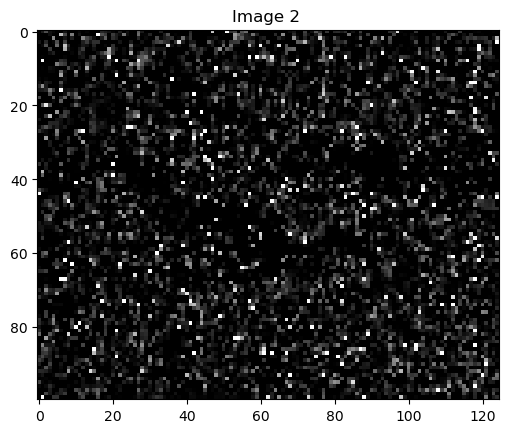

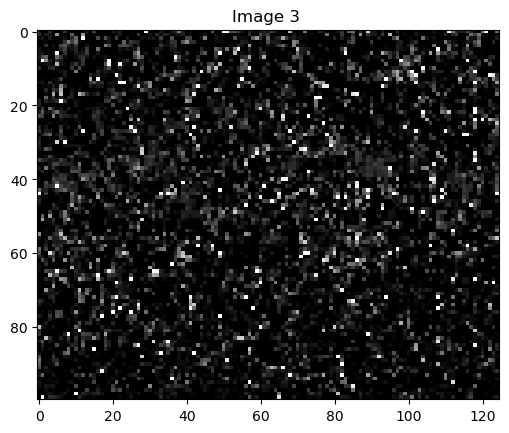

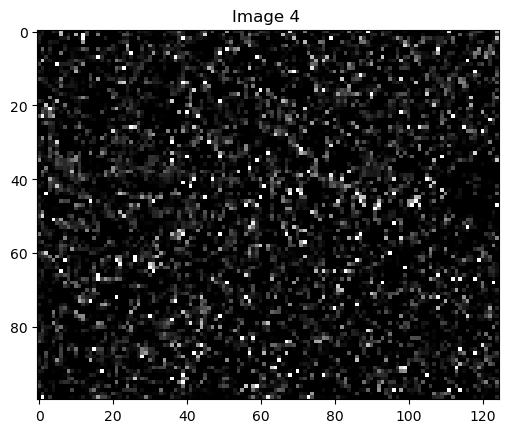

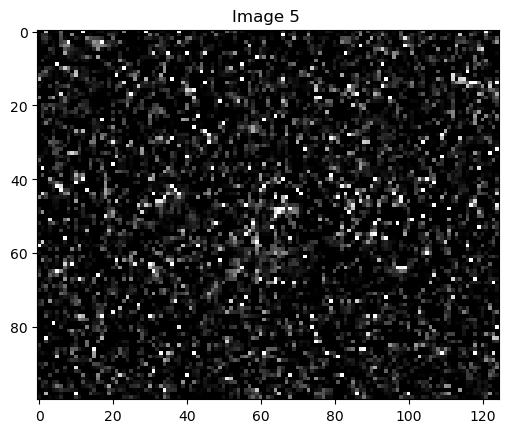

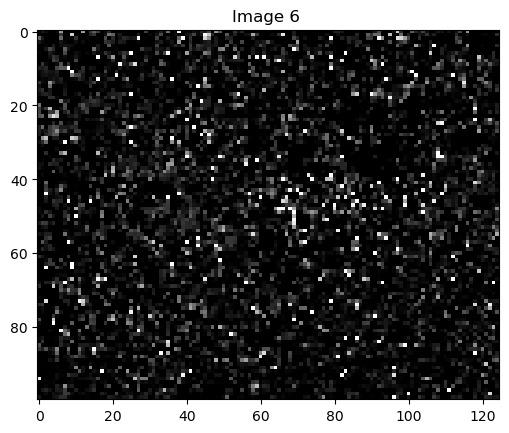

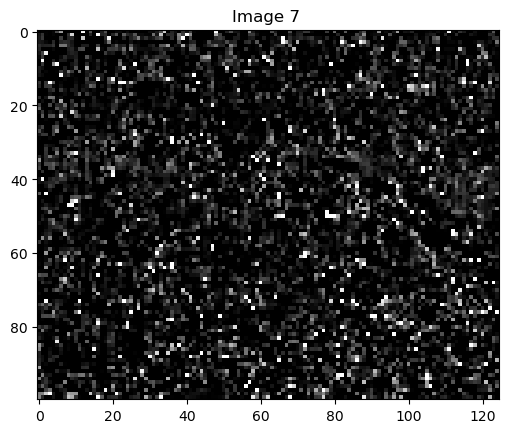

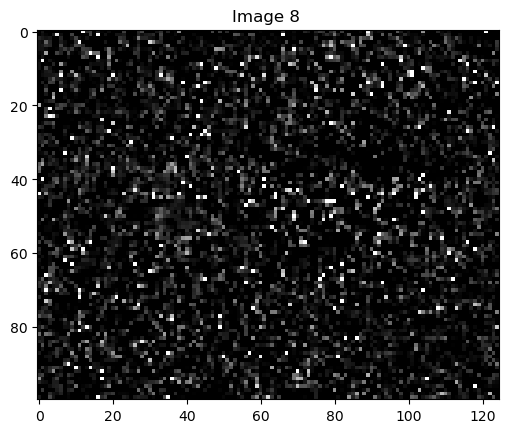

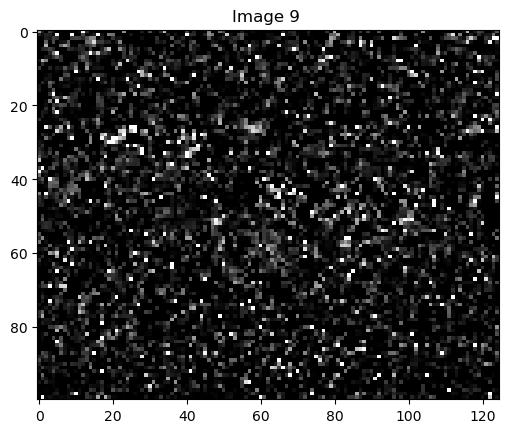

In [8]:
#affichage des image ratio réelles : 
nbr=len(Ratios)
vmax_values = [1/2] * nbr
for k in range(nbr):
    plt.imshow(np.abs(Ratios[k]), cmap="gray", vmax=vmax_values[k]* np.max(np.abs(Ratios[k])))
    plt.title(f"Image {k+1} ")
    plt.show()

# Denoising: 
Débruitage avec le filtre TV-Bregman (débruitage anisotrope) pour lisser l'image avec la fonction prédefinie  `denoise_tv_bregman` de skimage.



In [9]:

Images_denoised = []
for k in range(nbr):
    Images_denoised.append(denoise_tv_bregman(Ratios[k], weight=0.1))


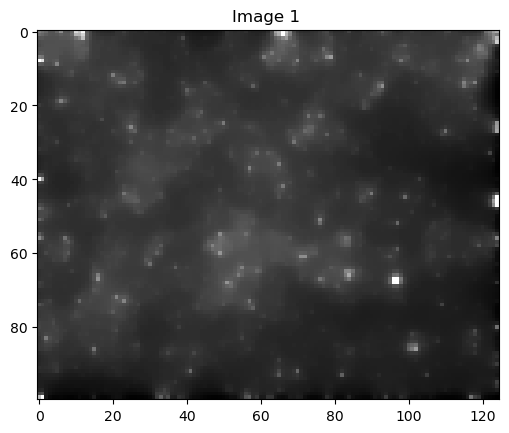

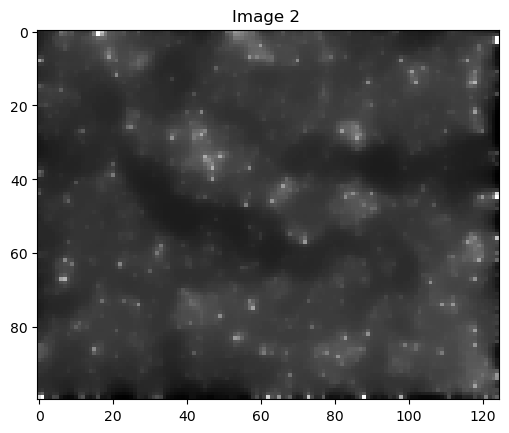

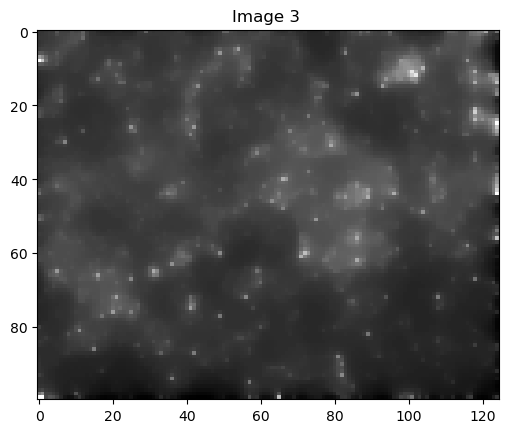

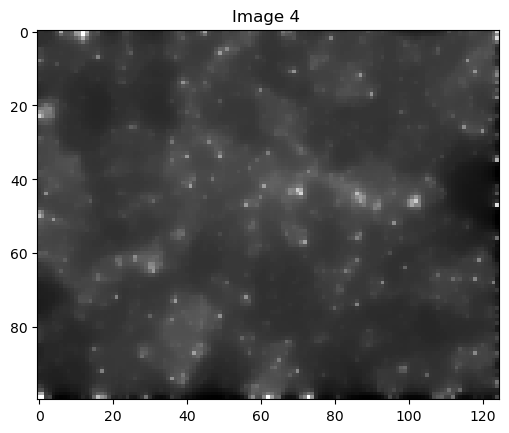

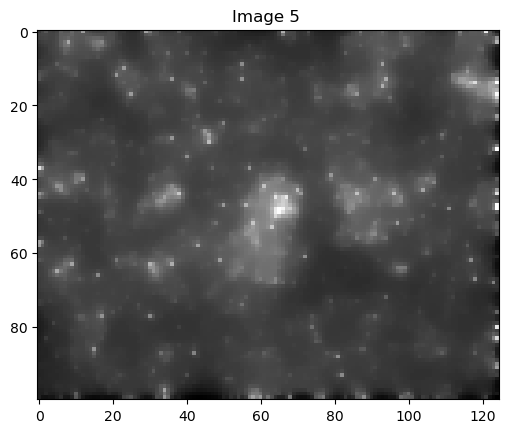

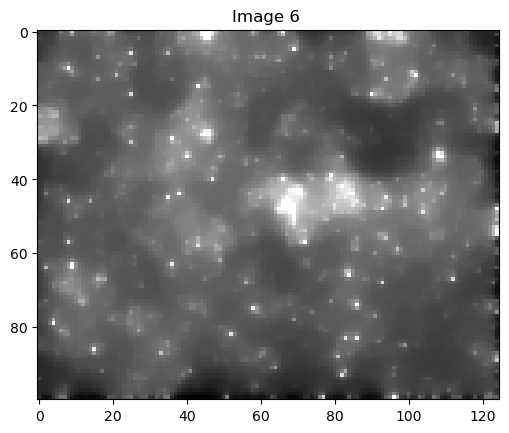

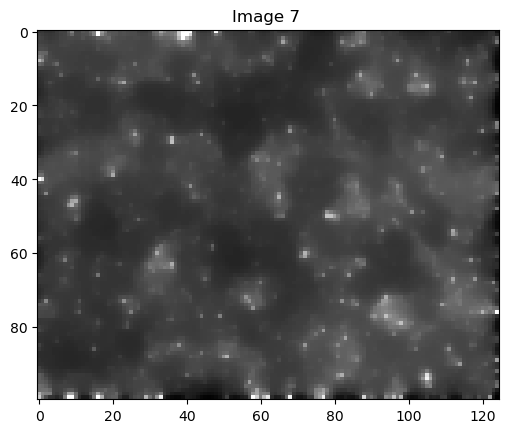

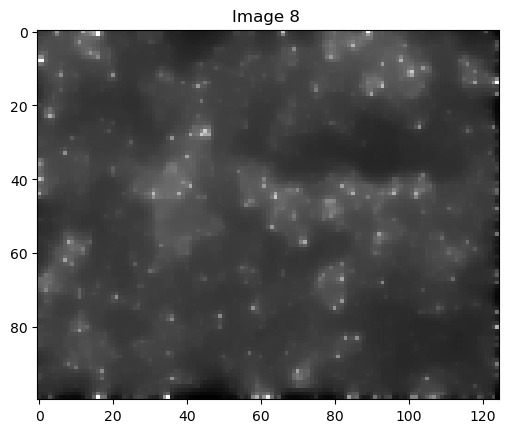

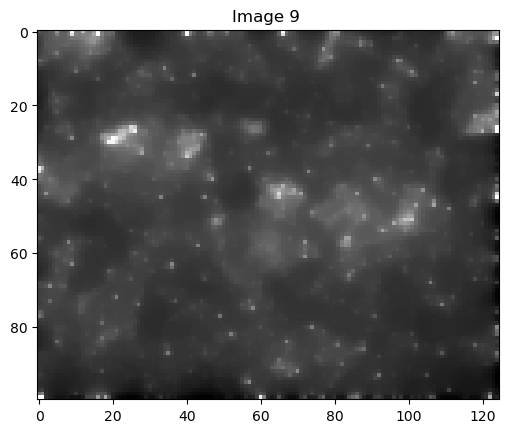

In [10]:
#affichage des images débruitées : 

for k in range(nbr):
    plt.imshow(Images_denoised[k], cmap="gray", vmax=vmax_values[k]* np.max(Images_denoised[k]))
    plt.title(f"Image {k+1} ")
    plt.show()

# Seuillage

In [13]:
def seuillage(image_gris, seuil):
    _, image_bw = cv2.threshold(image_gris, seuil, 255, cv2.THRESH_BINARY)
    return image_bw


# Spécifier le seuil 
seuil = 0.8
Images_bw = []

sx2 = np.s_[45:120] 
sy2 = np.s_[30:80]

# Appliquer le seuillage pour chaque image
for k in range(nbr):
    Images_bw.append(seuillage(Images_denoised[k], seuil))
    Images_bw[k] = Images_bw[k][sy2, sx2]


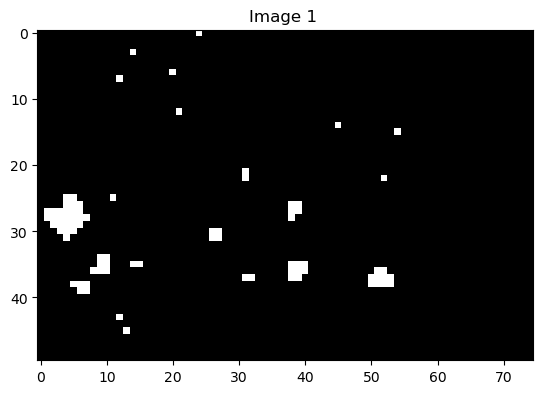

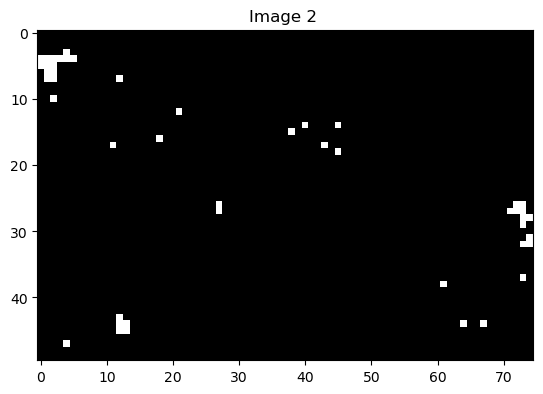

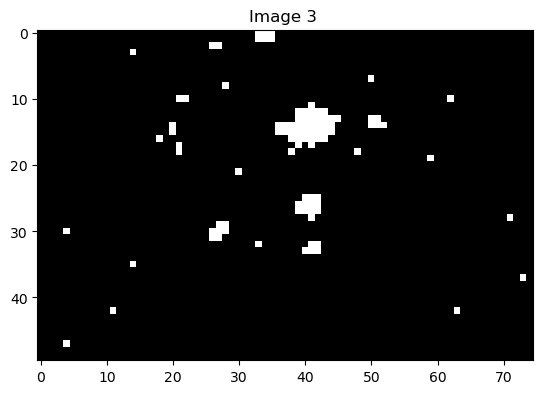

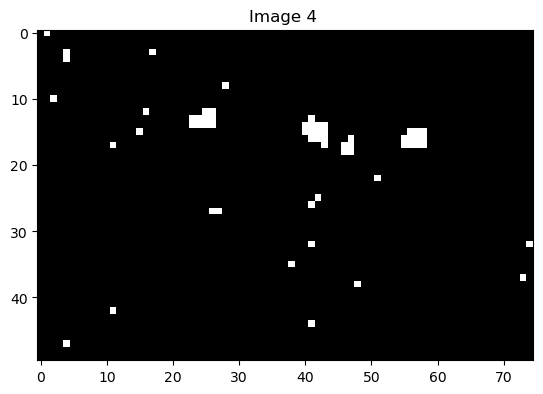

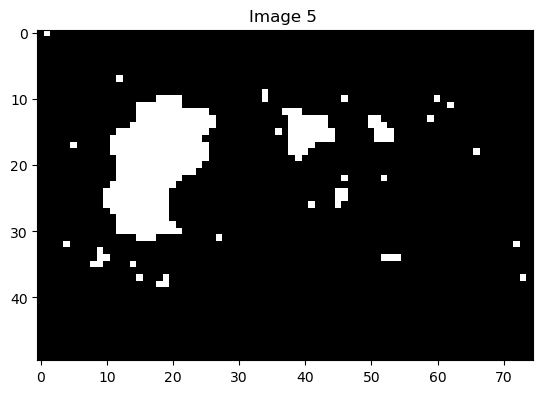

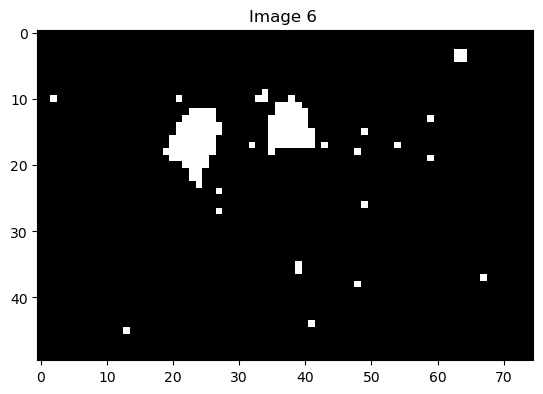

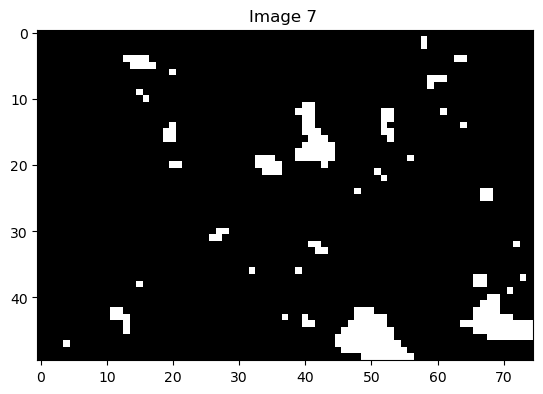

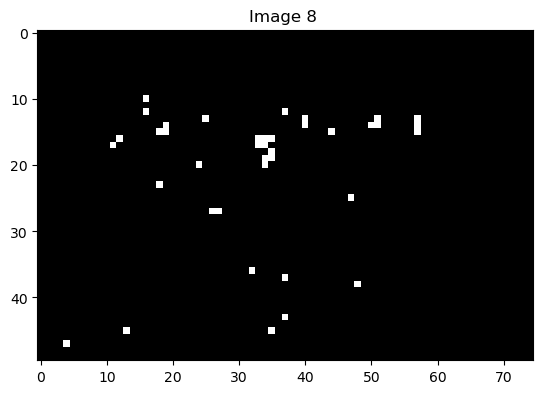

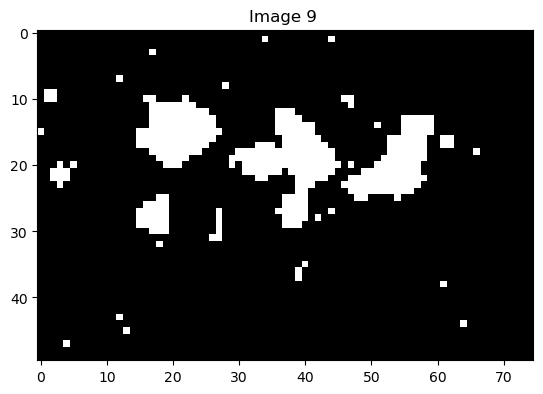

In [14]:
#affichage des images en noir et blanc: 

for k in range(nbr):
    plt.imshow(Images_bw[k], cmap="gray", vmax=1 * np.max(Images_bw[k]))
    plt.title(f"Image {k+1} ")
    plt.show()

# Traitement morphologique:
## Erosion: suppression des pixels blancs hors de la zone d'intérêt:
La fonction prédefinie `morphology.remove_small_objects` de la bibliothèque `skimage` est utilisée

In [15]:
from skimage import morphology, color


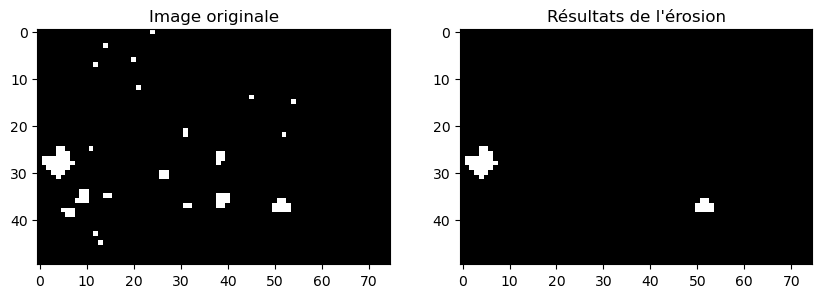

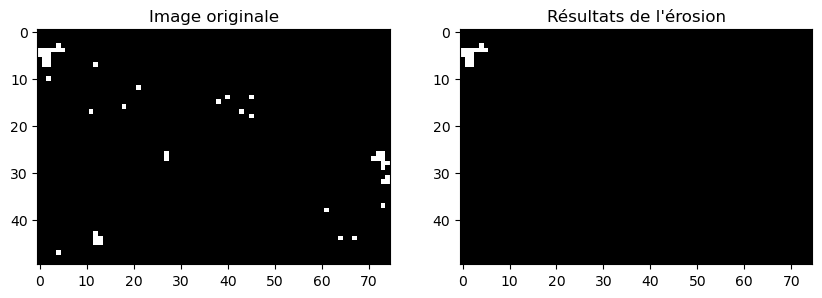

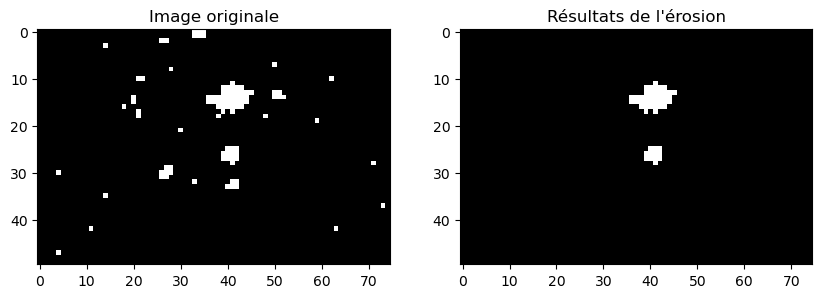

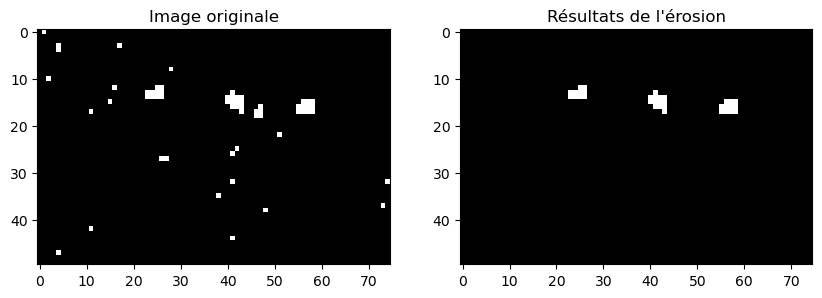

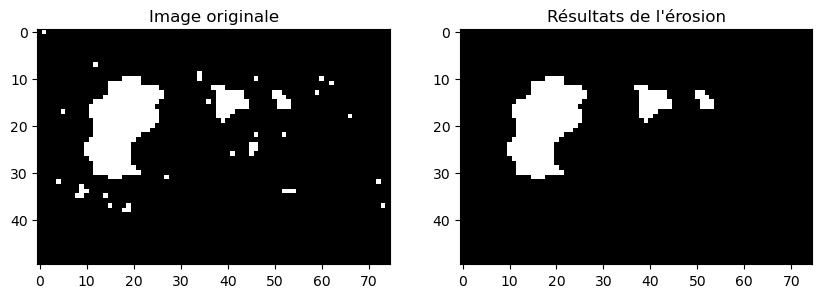

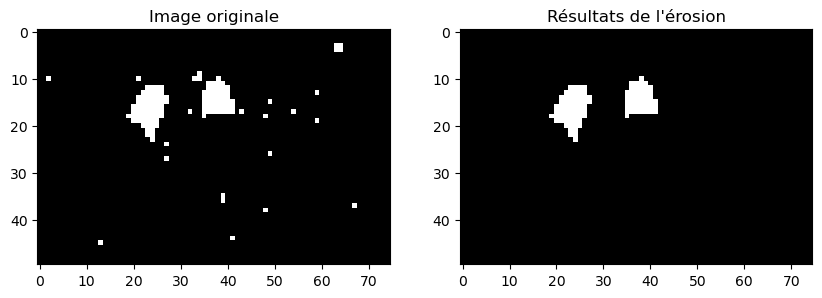

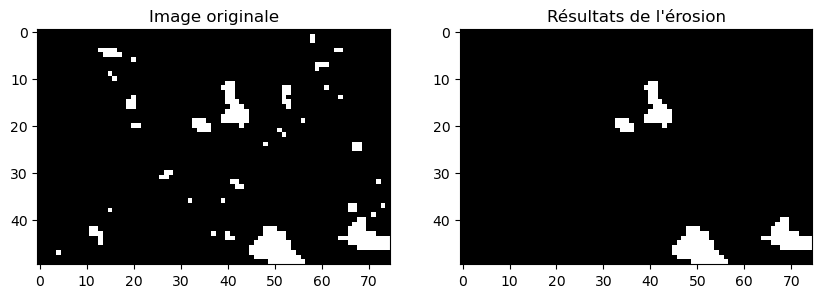

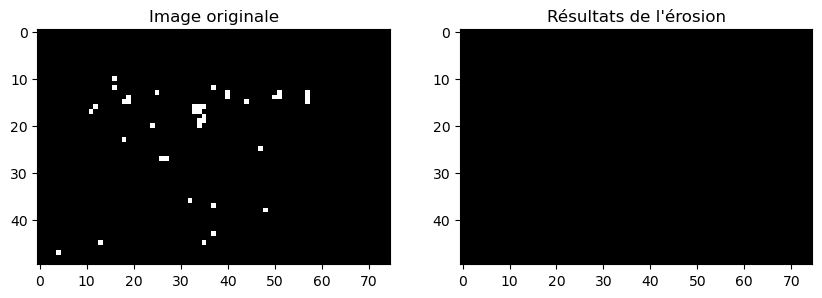

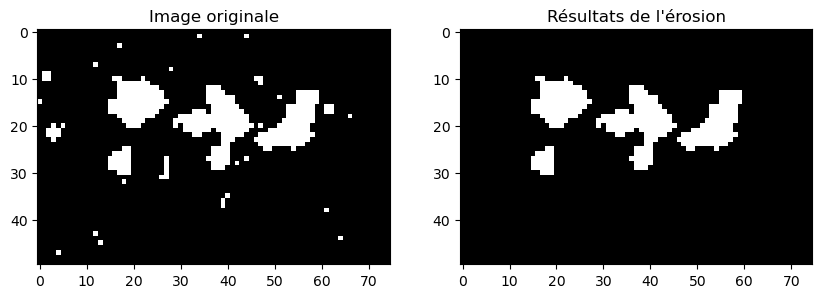

In [17]:

def remove_small_spots_skimage(image, min_size):

    # Binarisation l'image
    binary_image = image > 0.5  # Ajustez le seuil selon votre image

    # Utilisation de la fonction remove_small_objects
    binary_image_no_small = morphology.remove_small_objects(binary_image, min_size=min_size, connectivity=1)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(binary_image, cmap='gray')
    plt.title('Image originale')

    plt.subplot(1, 2, 2)
    plt.imshow(binary_image_no_small, cmap='gray')
    plt.title("Résultats de l'érosion")

    plt.show()

    return binary_image_no_small

min_size = 10  

Images_ero=[]
for k in range (nbr):
    Images_ero.append(remove_small_spots_skimage(Images_bw[k], min_size))

## Dilatation: remplir les lacunes dans la zone d'intérêt, fusionner les parties disjointes et élargir les contours
La fonction prédefinie `morphology.binary_dilation` de la bibliothèque `skimage` est utilisée

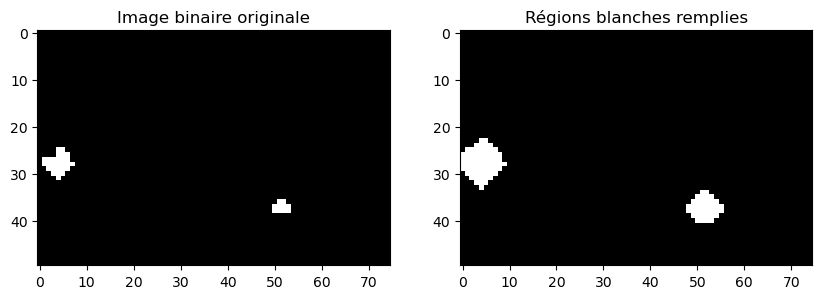

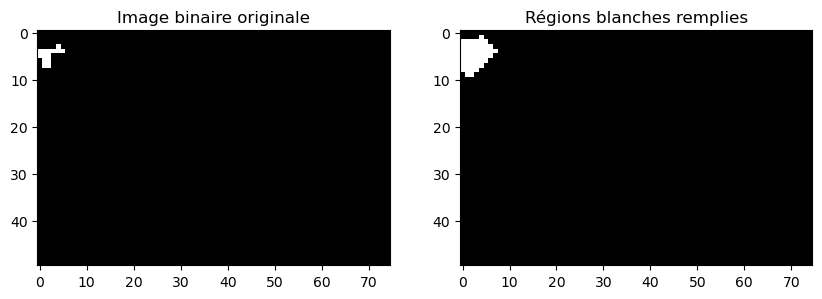

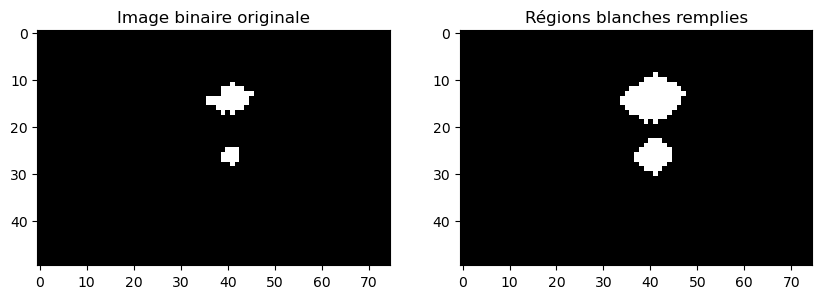

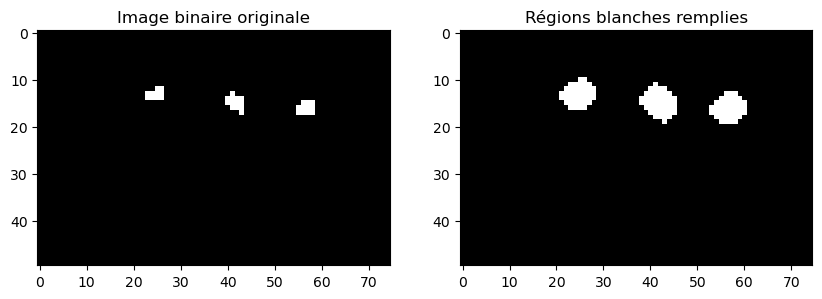

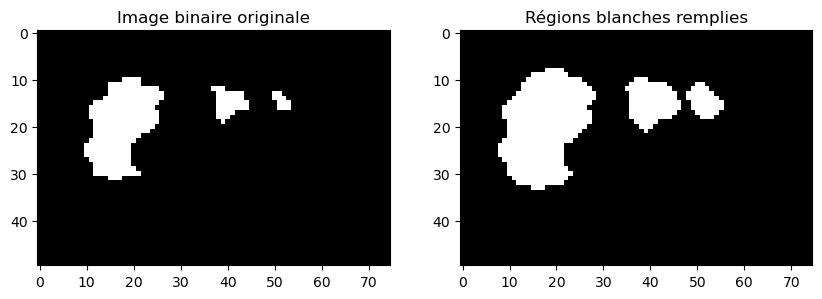

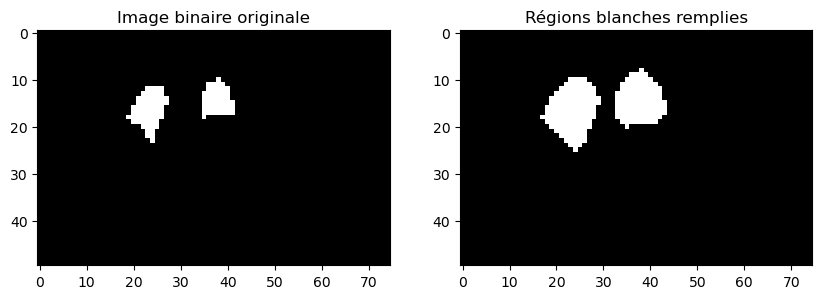

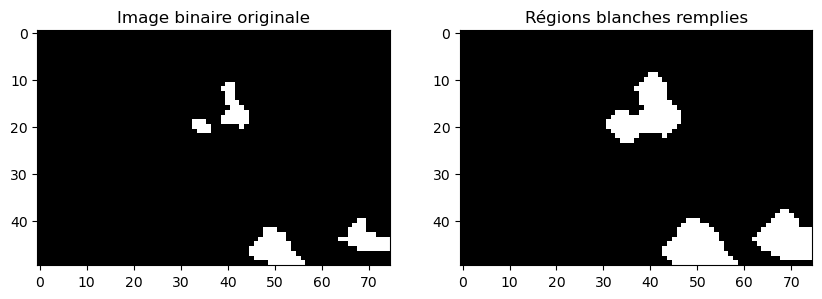

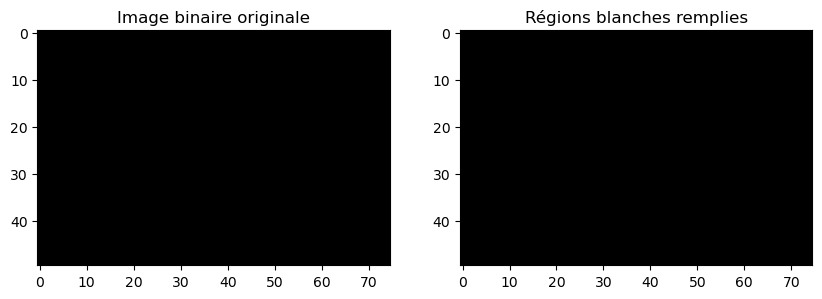

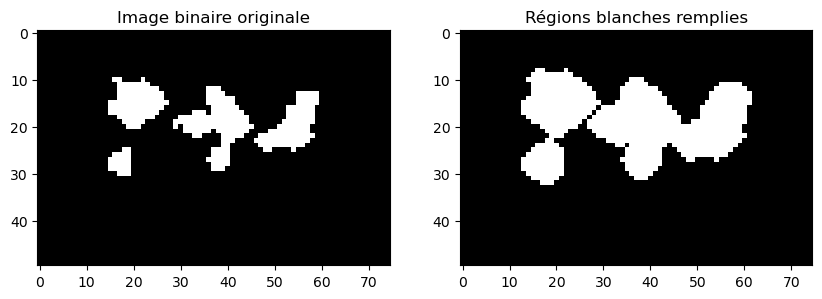

In [18]:
def fill_white_regions(image):
    # Convertir l'image en niveaux de gris si elle est en couleur
    if image.ndim == 3:
        image = color.rgb2gray(image)

    # Binariser l'image
    binary_image = image > 0.5  # Ajuster le seuil selon votre image

    # Utilisation de la dilatation binaire pour remplir les régions blanches
    footprint = morphology.disk(2)  # Ajuster la taille du disque au besoin
    filled_image = morphology.binary_dilation(binary_image, footprint=footprint)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(binary_image, cmap='gray')
    plt.title('Image binaire originale')

    plt.subplot(1, 2, 2)
    plt.imshow(filled_image, cmap='gray')
    plt.title('Régions blanches remplies')

    plt.show()

    return filled_image

Images_dil=[]
for k in range (nbr):
    Images_dil.append(fill_white_regions(Images_ero[k]))

 En remarquant que la 5ième image comporte encore des zones non remplies, nous définissons une fonction qui applique la dilatation avec la fonction `morphology.binary_dilation` sur les zones spécifiques à remplir 

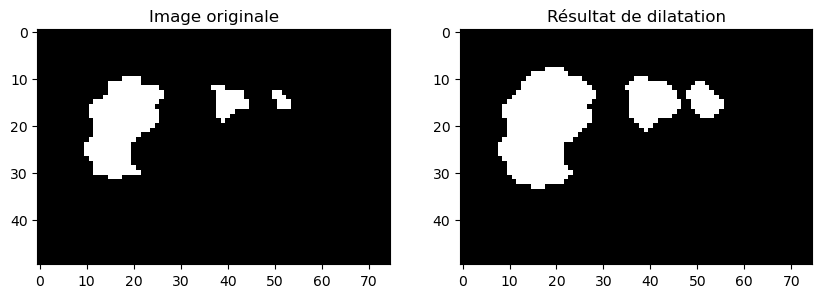

In [19]:
# Définition de la fonction pour remplir une zone spécifique dans une image
def fill_specific_zone(image, xmin, xmax, ymin, ymax, footprint_size):
    # Convertir l'image en niveaux de gris si elle est en couleur
    if image.ndim == 3:
        image = color.rgb2gray(image)

    # Copier l'image originale pour éviter de modifier l'entrée
    filled_image = np.copy(image)

    # Extraire la zone spécifiée de l'image
    zone = filled_image[ymin:ymax, xmin:xmax]

    # Créer un masque binaire pour la zone spécifiée
    binary_zone = zone > 0.5  # Ajuster le seuil selon votre image

    # Utiliser une dilatation binaire pour remplir la zone spécifiée avec une empreinte spécifiée
    footprint = morphology.disk(footprint_size)
    filled_zone = morphology.binary_dilation(binary_zone, footprint=footprint)

    # Mettre à jour l'image remplie avec la zone remplie
    filled_image[ymin:ymax, xmin:xmax] = filled_zone.astype(filled_image.dtype)

    return filled_image

# Spécifier la boîte englobante de la zone que vous souhaitez remplir
xmin, xmax, ymin, ymax = 80, 125, 80, 150

# Spécifier la taille de l'empreinte pour remplir la première zone 
# valeur ajustée au besoin de l'image
footprint_size = 3 

# Appliquer la fonction à vos images et à la zone spécifiée
filled_image_zone_1 = fill_specific_zone(Images_dil[4], xmin, xmax, ymin, ymax, footprint_size)

# Spécifier la boîte englobante de la zone que vous souhaitez remplir
xmin1, xmax1, ymin1, ymax1 = 70, 100, 40, 60

# Spécifier la taille de l'empreinte pour remplir la deuxième zone
# valeur ajustée au besoin de l'image
footprint_size1 = 8 

# Appliquer la fonction à vos images et à la zone spécifiée
Images_dil[4] = fill_specific_zone(filled_image_zone_1, xmin1, xmax1, ymin1, ymax1, footprint_size1)

# Visualiser les résultats
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(Images_ero[4], cmap='gray')
plt.title('Image originale')

plt.subplot(1, 2, 2)
plt.imshow(Images_dil[4], cmap='gray')
plt.title('Résultat de dilatation')

plt.show()



# Comptage du nombre de pixels blancs

In [20]:
# Compter le nombre de pixels blancs dans l'image

Nbr_pixels_blancs=[]
for k in range(nbr):
    Nbr_pixels_blancs.append(np.sum(Images_dil[k] == 1))
    print("Nombre de pixels de la zone blanche dans l'image numéro", k+1 ," {} pixels carrés".format(Nbr_pixels_blancs[k]))

Nombre de pixels de la zone blanche dans l'image numéro 1  104 pixels carrés
Nombre de pixels de la zone blanche dans l'image numéro 2  46 pixels carrés
Nombre de pixels de la zone blanche dans l'image numéro 3  134 pixels carrés
Nombre de pixels de la zone blanche dans l'image numéro 4  126 pixels carrés
Nombre de pixels de la zone blanche dans l'image numéro 5  494 pixels carrés
Nombre de pixels de la zone blanche dans l'image numéro 6  224 pixels carrés
Nombre de pixels de la zone blanche dans l'image numéro 7  322 pixels carrés
Nombre de pixels de la zone blanche dans l'image numéro 8  0 pixels carrés
Nombre de pixels de la zone blanche dans l'image numéro 9  654 pixels carrés


Dans notre cas de données sentinel-1 IW, la cellule de resolution a la taille de 5*20 m = 100 m²

In [21]:
surface=[]
for k in range(nbr):
    surface.append(Nbr_pixels_blancs[k]*100)
    print("Surface de la zone blanche dans l'image numéro", k+1 ," {} est m²".format(surface[k]))


Surface de la zone blanche dans l'image numéro 1  10400 est m²
Surface de la zone blanche dans l'image numéro 2  4600 est m²
Surface de la zone blanche dans l'image numéro 3  13400 est m²
Surface de la zone blanche dans l'image numéro 4  12600 est m²
Surface de la zone blanche dans l'image numéro 5  49400 est m²
Surface de la zone blanche dans l'image numéro 6  22400 est m²
Surface de la zone blanche dans l'image numéro 7  32200 est m²
Surface de la zone blanche dans l'image numéro 8  0 est m²
Surface de la zone blanche dans l'image numéro 9  65400 est m²


# Graphique du suivi des décharges

In [22]:
from datetime import datetime
from matplotlib.dates import AutoDateLocator, AutoDateFormatter, MonthLocator


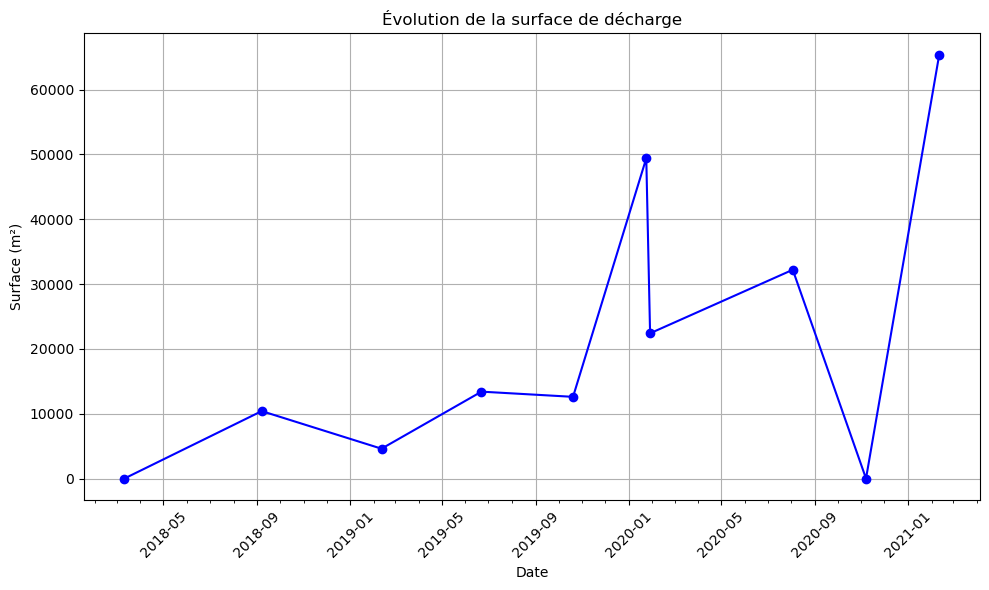

In [23]:
surface.insert(0,0)
# Conversion des dates en objets datetime
date_objects = [datetime.strptime(date, "%d/%m/%Y") for date in dates]
# Traçage de l'évolution de la surface en fonction des dates
plt.figure(figsize=(10, 6))
plt.plot(date_objects, surface , marker='o', linestyle='-', color='b')
plt.title('Évolution de la surface de décharge')
plt.xlabel('Date')
plt.ylabel('Surface (m²)')

# Utilisation AutoDateLocator pour ajuster automatiquement l'échelle des dates
locator = AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(AutoDateFormatter(locator))

# Ajouter les mois à l'axe des x
plt.gca().xaxis.set_minor_locator(MonthLocator())
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()


La courbe montre qu'à partir de janvier 2017, la superficie commence à augmenter progressivement, atteignant son pic avec une extension estimée à 1 km² en avril 2020. 

# Estimation du nombre de voitures: 

In [20]:
# Estimation de la surface de voitures en m²
surface_moyenne_voiture = 10

nombre_voitures_estime =[]
# Estimation du nombre de voitures
for k in range (nbr+1):
    nombre_voitures_estime.append( surface[k] / surface_moyenne_voiture)

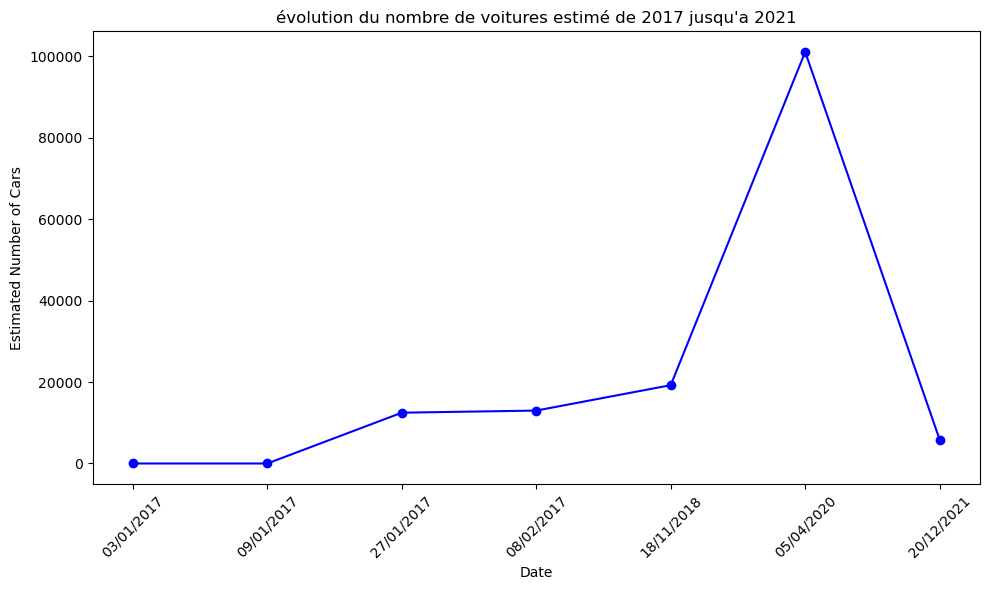

In [21]:
data = list(zip(dates,nombre_voitures_estime))

data.sort(key=lambda x: datetime.strptime(x[0], "%d/%m/%Y"))

sorted_dates, estimations = zip(*data)

plt.figure(figsize=(10, 6))
plt.plot(sorted_dates, estimations, marker='o', linestyle='-', color='b')
plt.title("évolution du nombre de voitures estimé de 2017 jusqu'a 2021")
plt.xlabel('Date')
plt.ylabel('Estimated Number of Cars')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


L'interprétation des tendances et des évolutions dans la superficie de la décharge des voitures à Victorville, en Californie, pourrait être incomplète en raison du nombre limité d'images examinées. Cependant, la force de ce code automatisé réside dans sa capacité à fournir des résultats rapidement. Une simple actualisation du fichier de départ et le relancement du code permettent d'obtenir des informations mises à jour sur l'état de la décharge, facilitant ainsi une analyse dynamique et réactive des changements observés au fil du temps.